# Field Reversed Configuration (FRC) Simulations

The FRC formed through an RMF can be characterized by two important dimensionless parameters, $\lambda=R/\delta$, where $\delta=(2\eta /\mu_o \omega)^{1/2}$ is the classical skin depth, and by $\gamma=\omega_{ce}/\nu_{ei}$, where $\nu_{ei}=\eta(ne^2/m_e)$ is the electron-ion collision frequency. In term of the system parameters, these two parameters can be expressed as

$$ \lambda = R \left(\frac{\mu_o\omega}{2\eta}\right)^{1/2} $$,

$$ \gamma = \frac{1}{e}\left(\frac{B_\omega}{n\eta}\right) $$.

The magnitude of the external-driving field must exceed a certain critical value before much current is driven in the plasma column.

The measure of the current drive is the parameter $\alpha$, which is defined as the ratio of the driven current divided by the current obtained if all of the electrons rotate synchronously with the RMF.

$$ \alpha = \frac{2}{\mu_o n e \omega R^2}\left(B_z(r=R) - B(r=0) \right) $$

In [1]:
#######  IMPORTS ###########
import os
import re
import vtk

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

from vtk.util.numpy_support import vtk_to_numpy

# import pandas and seaborn
import pandas as pd
import seaborn as sns

#import scikit-learn function
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve


/usr/lib/pymodules/python2.7/matplotlib/axes.py:4747: UserWarning: No labeled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labeled objects found. "


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


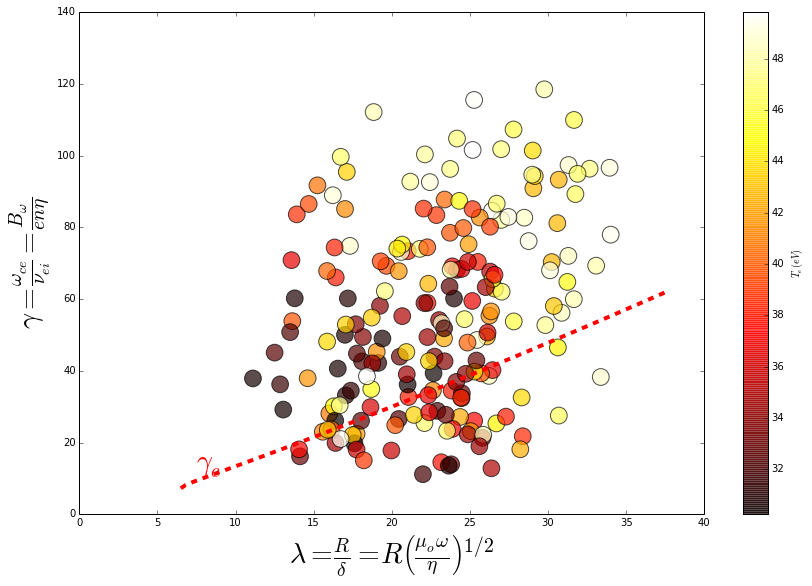

In [2]:
number = 200 # Sample size

def calRatio(w, Bw, Te):
    mu_o = np.pi*4.e-7
    e = 1.602e-19

    n = 1.0e20
    R = 0.03
    loglambda = 10.

    eta = 5.2e-5*loglambda/(Te)**1.5
    #eta = 1.65e-9*loglambda/(Te/1.e3)**1.5

    gamma = Bw/e/n/eta
    lmbda = R*np.sqrt(0.5*mu_o*w/eta)

    return gamma, lmbda

def gammaCritical(lbd):
    return 1.12*lbd*(1.0+0.12*(lbd-6.5)**0.4)

def getSelectionInRange(var, rmin, rmax, sample):
    a = np.where(var>rmin)
    b = np.where(var<rmax)
    intersec = np.intersect1d(a,b)

    if(sample<len(intersec)):
        randSample = np.random.randint(len(intersec), size=sample)
        res = intersec[randSample]
    else:
        res = intersec

    return res

def plot_the_classification_regions_and_data(X_train,y_train, X_test,y_test,classifier,scaler,title):
    
    X_set, y_set = X_train, y_train
    X1, X2 = np.meshgrid(np.arange(start=X_set[:,0].min()-1, stop=X_set[:,0].max()+1, step=0.01),
                         np.arange(start=X_set[:,1].min()-1, stop=X_set[:,1].max()+1, step=0.01))
    
    Areas = classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)
    
    
    X1, X2 = np.meshgrid(np.arange(start=X_set[:,0].min()-1, stop=X_set[:,0].max()+1, step=0.01),
                         np.arange(start=X_set[:,1].min()-1, stop=X_set[:,1].max()+1, step=0.01))
    
    Xit = scaler.inverse_transform(np.array([X1.ravel(), X2.ravel()]).T)
    X1 = Xit[:,0].reshape(X1.shape)
    X2 = Xit[:,1].reshape(X2.shape)    
    
    plt.figure(figsize=(14,9))
    plt.contourf(X1,X2,Areas, alpha=0.75, cmap= ListedColormap(('red', 'green')))
    
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())
    
    ln = ['no_train','yes_train']
    
    X_set = scaler.inverse_transform(X_train)
    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set==j, 0], X_set[y_set==j,1],
                    c=ListedColormap(('red','green'))(i), s=280, alpha=0.7)
        
    lt = ['no_test','yes_test']
    X_tt = scaler.inverse_transform(X_test)
    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_tt[y_test==j, 0], X_tt[y_test==j,1],
                    c=ListedColormap(('magenta','cyan'))(i), s=280, alpha=0.7)
    
    xx = np.linspace(X_set[:,0].min()-1,X_set[:,0].max()+1,1000)
    plt.plot(xx,gammaCritical(xx),'b--',lw=4.)
    
    plt.title(title)
    plt.xlabel(r"$\lambda = \frac{R}{\delta} = R\left(\frac{\mu_o\omega}{\eta}\right)^{1/2}$",fontsize=28)
    plt.ylabel(r"$\gamma = \frac{\omega_{ce}}{\nu_{ei}} = \frac{B_\omega}{en\eta}$",fontsize=28)
    plt.legend()

omega = np.zeros(number)
Bomega= np.zeros(number)
Temp  = np.zeros(number)
lam   = np.zeros(number)
gam   = np.zeros(number)
gol   = np.zeros(number)

np.random.seed(4)
for k in range(number):
    omega[k] = np.random.uniform(2*np.pi*1.e5,2*np.pi*5.e5)
    Bomega[k]= np.random.uniform(5.e-4,30.e-4)
    Temp[k]  = np.random.uniform(30.,50.)
    gam[k], lam[k]   = calRatio(omega[k], Bomega[k], Temp[k])
    gol[k] = gam[k]/lam[k]

plt.figure(figsize=(14,9))
sc = plt.scatter(lam, gam, c=Temp, cmap="hot", alpha=0.7,s=280)

cb = plt.colorbar(sc, label=r'$T_e (eV)$')
plt.legend()
plt.xlabel(r"$\lambda = \frac{R}{\delta} = R\left(\frac{\mu_o\omega}{\eta}\right)^{1/2}$",fontsize=28)
plt.ylabel(r"$\gamma = \frac{\omega_{ce}}{\nu_{ei}} = \frac{B_\omega}{en\eta}$",fontsize=28)
#plt.plot([0.2*pi,3.3],[1.,1.],'k--',lw=2.)
#plt.xlim(0.2*pi,3.3)

xx = np.linspace(6.5,37.5,100)
yy = gammaCritical(xx)
plt.plot(xx,yy,'r--',lw=4.)
plt.text(7.5,12.,r"$\gamma_c$",fontsize=28,color='red')

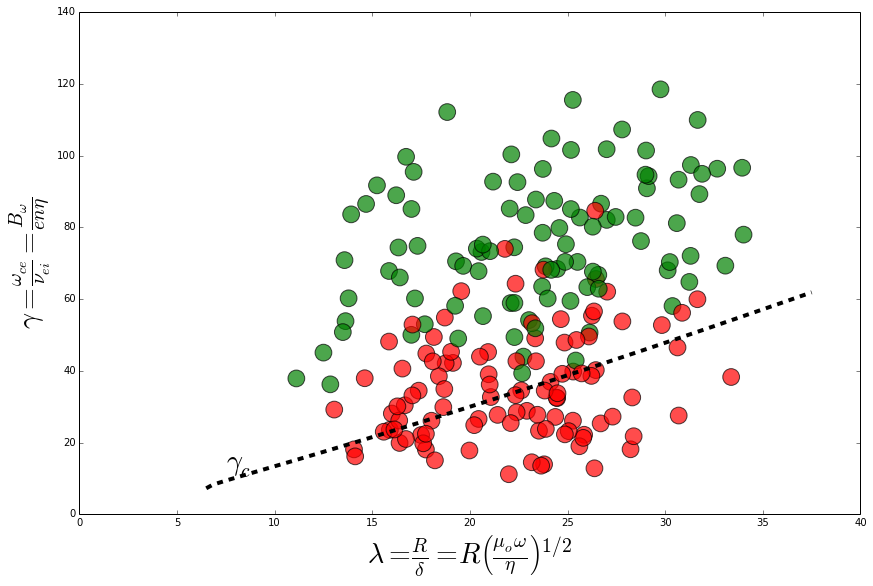

In [3]:
## Get the data
thedir  = '/home/sousae/simulationsApollo/rmf_frc/dataAnalysis'
frc = np.genfromtxt(thedir+'/frc_post_data.txt')

plt.figure(figsize=(14,9))
sc = plt.scatter(frc[:,3], frc[:,4], c=frc[:,11], cmap=ListedColormap(('red', 'green')), alpha=0.7,s=280)

#cb = plt.colorbar(sc, label=r'$B_z Reversal$')
#plt.legend()
plt.xlabel(r"$\lambda = \frac{R}{\delta} = R\left(\frac{\mu_o\omega}{\eta}\right)^{1/2}$",fontsize=28)
plt.ylabel(r"$\gamma = \frac{\omega_{ce}}{\nu_{ei}} = \frac{B_\omega}{en\eta}$",fontsize=28)
#plt.plot([0.2*pi,3.3],[1.,1.],'k--',lw=2.)
#plt.xlim(0.2*pi,3.3)

xx = np.linspace(6.5,37.5,100)
yy = gammaCritical(xx)
plt.plot(xx,yy,'k--',lw=4.)
plt.text(7.5,12.,r"$\gamma_c$",fontsize=28,color='black')

In [4]:
# lets separate the features and the targets
X = frc[:,3:5]
y = frc[:,11]

# do the train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=0)

# Scale the features
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [5]:
help(LogisticRegression)
# Create the hyperparameter grid
c_space = np.linspace(3, 4, 20)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

Help on class LogisticRegression in module sklearn.linear_model.logistic:

class LogisticRegression(sklearn.base.BaseEstimator, sklearn.linear_model.base.LinearClassifierMixin, sklearn.linear_model.base.SparseCoefMixin)
 |  Logistic Regression (aka logit, MaxEnt) classifier.
 |  
 |  In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
 |  scheme if the 'multi_class' option is set to 'ovr', and uses the cross-
 |  entropy loss if the 'multi_class' option is set to 'multinomial'.
 |  (Currently the 'multinomial' option is supported only by the 'lbfgs',
 |  'sag' and 'newton-cg' solvers.)
 |  
 |  This class implements regularized logistic regression using the
 |  'liblinear' library, 'newton-cg', 'sag' and 'lbfgs' solvers. It can handle
 |  both dense and sparse input. Use C-ordered arrays or CSR matrices
 |  containing 64-bit floats for optimal performance; any other input format
 |  will be converted (and copied).
 |  
 |  The 'newton-cg', 'sag', and 'lbfgs' solve

In [6]:
# fitting logistic Regression to the training set
classifier = LogisticRegression(random_state=0)

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(classifier, param_grid, cv=5)

# Fit it to the training data
logreg_cv.fit(X_train, y_train)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameter: {'penalty': 'l2', 'C': 3.4210526315789473}
Tuned Logistic Regression Accuracy: 0.886666666667


In [7]:
classifier = LogisticRegression(random_state=0, penalty='l2', C=3.4210526315789473)
classifier.fit(X_train, y_train)

LogisticRegression(C=3.42105263158, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [8]:
# predict the test set results
y_pred = classifier.predict(X_test)

# Making the confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[22  1]
 [ 4 23]]


/usr/local/lib/python2.7/dist-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python2.7/dist-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


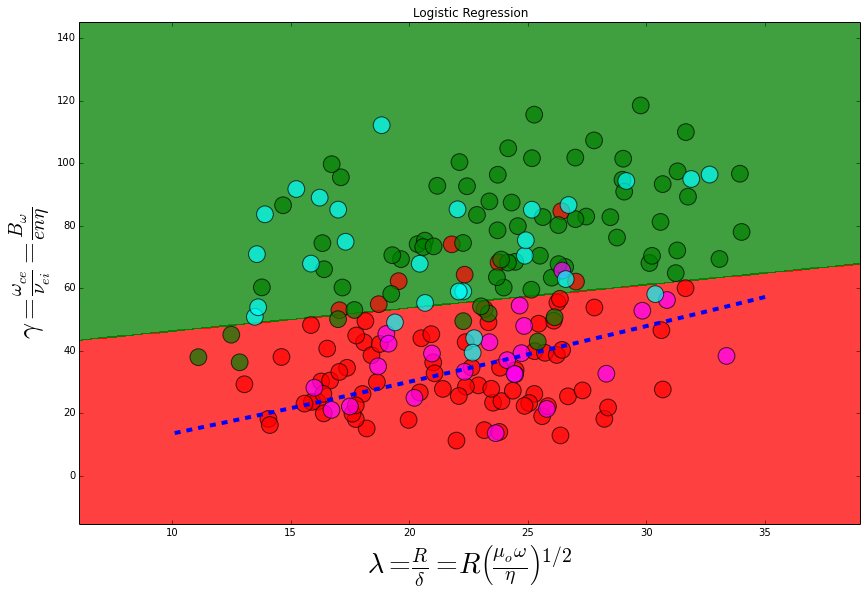

In [9]:
plot_the_classification_regions_and_data(X_train,y_train, X_test,y_test,classifier,sc_X,'Logistic Regression')

In [10]:
# Analysis
y_pred_prob = classifier.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_prob)

In [11]:
help(KNeighborsClassifier)

Help on class KNeighborsClassifier in module sklearn.neighbors.classification:

class KNeighborsClassifier(sklearn.neighbors.base.NeighborsBase, sklearn.neighbors.base.KNeighborsMixin, sklearn.neighbors.base.SupervisedIntegerMixin, sklearn.base.ClassifierMixin)
 |  Classifier implementing the k-nearest neighbors vote.
 |  
 |  Read more in the :ref:`User Guide <classification>`.
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, optional (default = 5)
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |  
 |  weights : str or callable, optional (default = 'uniform')
 |      weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |        are weighted equally.
 |      - 'distance' : weight points by the inverse of their distance.
 |        in this case, closer neighbors of a query point will have a
 |        greater influence than neighbors which are further away.
 |      - [ca

In [12]:
param_grid = {'n_neighbors': np.arange(1, 50),
              'p': np.arange(1,5)} # grid dictionary
classifier = KNeighborsClassifier(metric='minkowski')
knn_cv = GridSearchCV(classifier, param_grid, cv=5)
knn_cv.fit(X_train, y_train)
# Print the optimal parameters and best score
print("Tuned K-Nearest Neighbors Parameter: {}".format(knn_cv.best_params_))
print("Tuned K-Nearest Neighbors Accuracy: {}".format(knn_cv.best_score_))

Tuned K-Nearest Neighbors Parameter: {'n_neighbors': 5, 'p': 1}
Tuned K-Nearest Neighbors Accuracy: 0.893333333333


[[20  3]
 [ 5 22]]


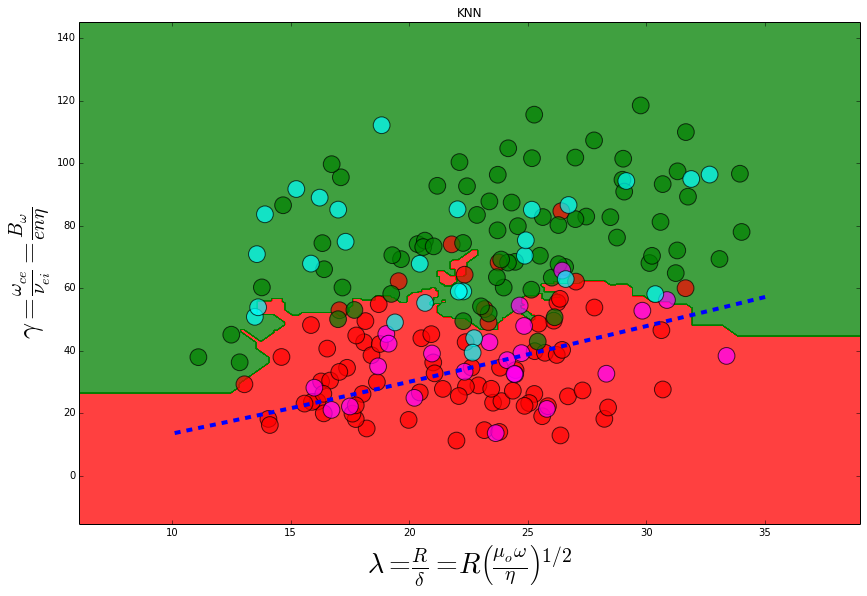

In [13]:
## K-Nearest Neighbors
classifier = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=1) # euclidian distances
classifier.fit(X_train,y_train)
# predict the test set results
y_pred = classifier.predict(X_test)

# Making the confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
plot_the_classification_regions_and_data(X_train,y_train, X_test,y_test,classifier,sc_X,'KNN')

In [14]:
# Analysis
y_pred_prob = classifier.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_prob)

In [15]:
help(SVC)

Help on class SVC in module sklearn.svm.classes:

class SVC(sklearn.svm.base.BaseSVC)
 |  C-Support Vector Classification.
 |  
 |  The implementation is based on libsvm. The fit time complexity
 |  is more than quadratic with the number of samples which makes it hard
 |  to scale to dataset with more than a couple of 10000 samples.
 |  
 |  The multiclass support is handled according to a one-vs-one scheme.
 |  
 |  For details on the precise mathematical formulation of the provided
 |  kernel functions and how `gamma`, `coef0` and `degree` affect each
 |  other, see the corresponding section in the narrative documentation:
 |  :ref:`svm_kernels`.
 |  
 |  Read more in the :ref:`User Guide <svm_classification>`.
 |  
 |  Parameters
 |  ----------
 |  C : float, optional (default=1.0)
 |      Penalty parameter C of the error term.
 |  
 |  kernel : string, optional (default='rbf')
 |       Specifies the kernel type to be used in the algorithm.
 |       It must be one of 'linear', 'poly

In [16]:
param_grid = {'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
              'degree': np.arange(1,5),
              'gamma': np.logspace(-5,-3,10)}
classifier = SVC(random_state=0, probability=True)
cv = GridSearchCV(classifier, param_grid, cv=5)
cv.fit(X_train, y_train)
# Print the optimal parameters and best score
print("Tuned SVM Parameter: {}".format(cv.best_params_))
print("Tuned SVM Accuracy: {}".format(cv.best_score_))

Tuned SVM Parameter: {'kernel': 'linear', 'gamma': 1e-05, 'degree': 1}
Tuned SVM Accuracy: 0.873333333333


[[22  1]
 [ 5 22]]


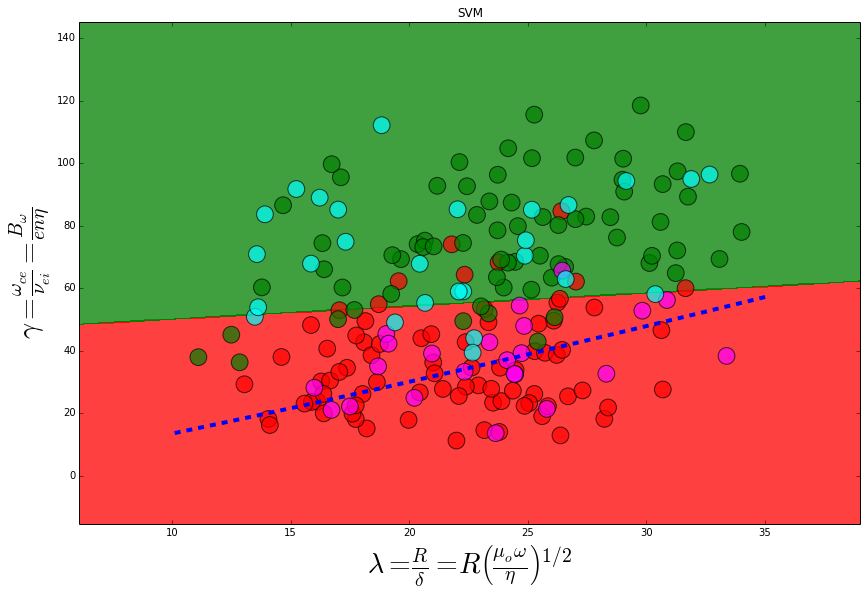

In [17]:
# fit SVM to the data
classifier = SVC(kernel='linear', random_state=0, probability=True, gamma=0.0001) ## kernels: 'linear, 'rbf'
classifier.fit(X_train,y_train)

# predict the test set results
y_pred = classifier.predict(X_test)

# Making the confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

plot_the_classification_regions_and_data(X_train,y_train, X_test,y_test,classifier,sc_X,'SVM')

In [18]:
# Analysis
y_pred_prob = classifier.predict_proba(X_test)[:,1]
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_pred_prob)

In [19]:
help(GaussianNB)

Help on class GaussianNB in module sklearn.naive_bayes:

class GaussianNB(BaseNB)
 |  Gaussian Naive Bayes (GaussianNB)
 |  
 |  Can perform online updates to model parameters via `partial_fit` method.
 |  For details on algorithm used to update feature means and variance online,
 |  see Stanford CS tech report STAN-CS-79-773 by Chan, Golub, and LeVeque:
 |  
 |      http://i.stanford.edu/pub/cstr/reports/cs/tr/79/773/CS-TR-79-773.pdf
 |  
 |  Read more in the :ref:`User Guide <gaussian_naive_bayes>`.
 |  
 |  Parameters
 |  ----------
 |  priors : array-like, shape (n_classes,)
 |      Prior probabilities of the classes. If specified the priors are not
 |      adjusted according to the data.
 |  
 |  Attributes
 |  ----------
 |  class_prior_ : array, shape (n_classes,)
 |      probability of each class.
 |  
 |  class_count_ : array, shape (n_classes,)
 |      number of training samples observed in each class.
 |  
 |  theta_ : array, shape (n_classes, n_features)
 |      mean of eac

[[20  3]
 [ 6 21]]
SVM Accuracy: 0.82


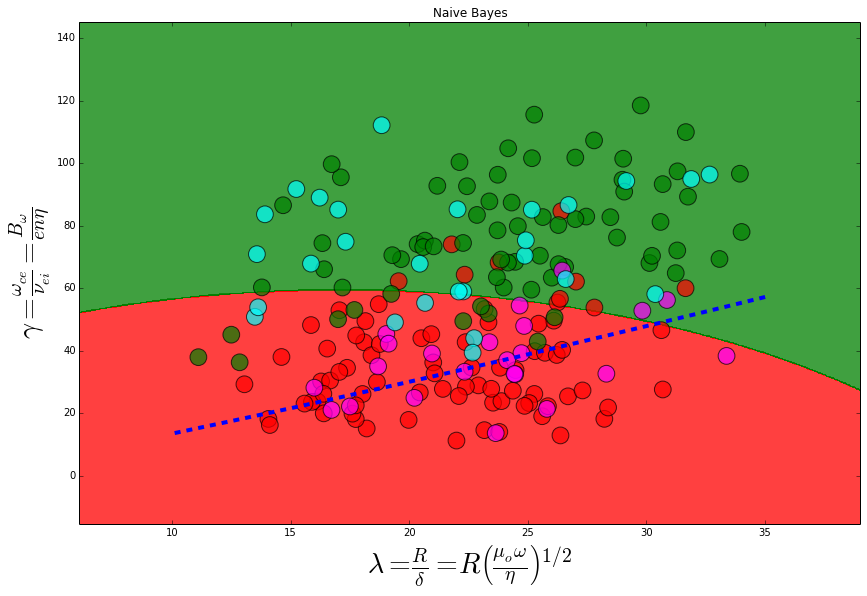

In [20]:
# Fit Naive Bayes to the data
classifier = GaussianNB()
classifier.fit(X_train,y_train)

# predict the test set results
y_pred = classifier.predict(X_test)

# Making the confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

plot_the_classification_regions_and_data(X_train,y_train, X_test,y_test,classifier,sc_X,'Naive Bayes')
print("SVM Accuracy: {}".format(accuracy_score(y_test, y_pred, normalize=True)))

In [21]:
# SVM Analysis
y_pred_prob = classifier.predict_proba(X_test)[:,1]
fpr4, tpr4, thresholds4 = roc_curve(y_test, y_pred_prob)

In [22]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble.forest:

class RandomForestClassifier(ForestClassifier)
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and use averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is always the same as the original
 |  input sample size but the samples are drawn with replacement if
 |  `bootstrap=True` (default).
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------
 |  n_estimators : integer, optional (default=10)
 |      The number of trees in the forest.
 |  
 |  criterion : string, optional (default="gini")
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |      Note: this parameter is tree-specific.
 |  
 |  max_features : int, fl

In [23]:
param_grid = {"max_depth": [3, 4, 5, None],
              "n_estimators": np.arange(10,110,10),
              "criterion": ["gini", "entropy"]}

classifier = RandomForestClassifier(random_state=0)
cv = GridSearchCV(classifier, param_grid, cv=5)

cv.fit(X_train, y_train)

# Print the optimal parameters and best score
print("Tuned SVM Parameter: {}".format(cv.best_params_))
print("Tuned SVM Accuracy: {}".format(cv.best_score_))

Tuned SVM Parameter: {'n_estimators': 60, 'criterion': 'gini', 'max_depth': 3}
Tuned SVM Accuracy: 0.893333333333


[[21  2]
 [ 4 23]]


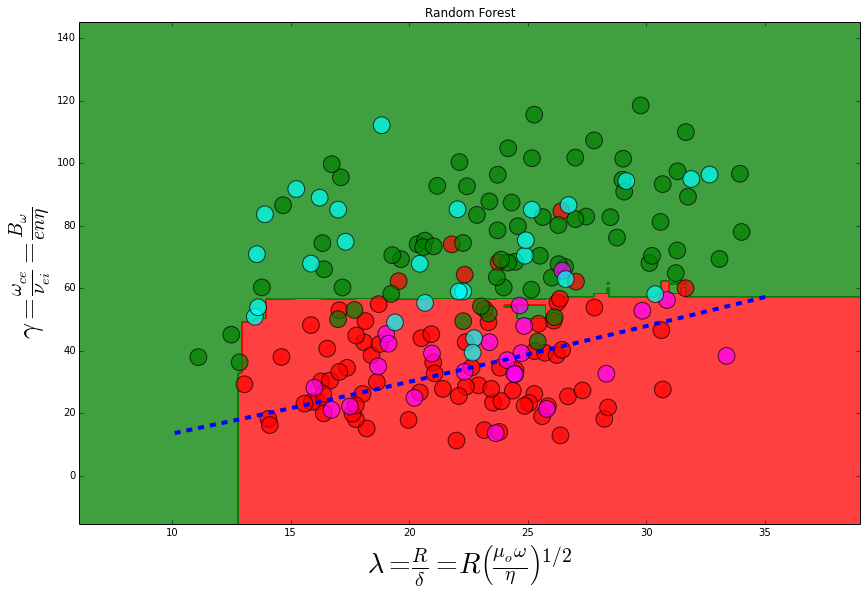

In [30]:
# Fit Random Forest to the training data
classifier = RandomForestClassifier(n_estimators=60, criterion='gini', max_depth=3, random_state=0)
classifier.fit(X_train,y_train)

# predict the test set results
y_pred = classifier.predict(X_test)

# Making the confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
plot_the_classification_regions_and_data(X_train,y_train, X_test,y_test,classifier,sc_X,'Random Forest')

In [25]:
# Analysis
y_pred_prob = classifier.predict_proba(X_test)[:,1]
fpr5, tpr5, thresholds5 = roc_curve(y_test, y_pred_prob)

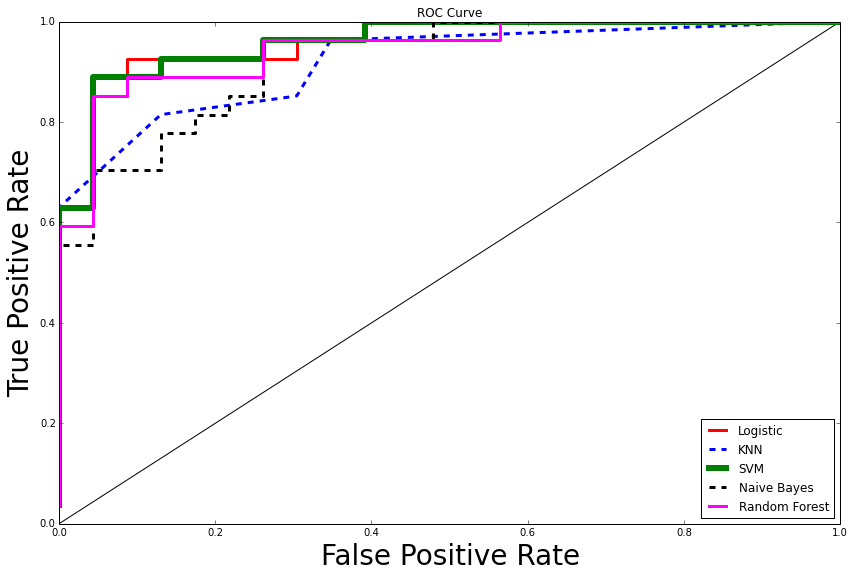

In [31]:
plt.figure(figsize=(14,9))
plt.plot([0, 1], [0, 1], 'k')
plt.plot(fpr1, tpr1, 'r',  label='Logistic',lw=3)
plt.plot(fpr2, tpr2, 'b--',label='KNN',lw=3)
plt.plot(fpr3, tpr3, 'g',label='SVM',lw=6)
plt.plot(fpr4, tpr4, 'k--',label='Naive Bayes',lw=3)
plt.plot(fpr5, tpr5, color='magenta',label='Random Forest',lw=3)
plt.xlabel('False Positive Rate',fontsize=28)
plt.ylabel('True Positive Rate',fontsize=28)
plt.title('ROC Curve')
plt.legend(loc='lower right')